# Network Intrusion Detection on DataSense: CIC IIoT 2025 (1-Second Windows)

This notebook builds a **modular and share-safe** ML pipeline for the **CIC IIoT 2025** (DataSense) dataset.  
It supports **1–10 s** window CSVs, synced sensor+network features, and both **binary** and **multiclass** tasks.

## ⚙️ Pipeline Overview
1. Load and combine the 1-second attack & benign CSVs, then **shuffle** the rows.
2. Do **light cleaning** and prepare features.
3. Use **ANOVA (f-test)** to rank features and select the most informative ones.
4. Use **Stratified K-Fold** cross-validation for robust evaluation.
5. Train baseline models:
   - Logistic Regression  
   - SVM (RBF)  
   - Random Forest  
6. Train additional models:
   - K-Means clustering (unsupervised ⇒ mapped to labels)  
   - K-Nearest Neighbors (KNN)  
   - LightGBM (if installed)  
   - XGBoost (if installed)
7. Compare models using:
   - Accuracy  
   - **Macro F1-score** (primary)  
   - Full classification report  
   - Confusion matrix for the best model


**Dependencies:** `python-dotenv`, `pandas`, `numpy`, `scikit-learn`, `matplotlib`, `seaborn`, `joblib`, `lightgbm`, `imbalanced-learn`

### Setup & Imports

In [1]:
# 0) Imports & configuration
import os
import warnings
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### 1. Load & Combine 1-Second CSVs (Shuffled)

In [2]:
load_dotenv("/home/jovyan/Notebooks/.env")
base_path = os.getenv("DATA_PATH")
# Sanity check
print("Base data path:", base_path)

attack_file = "attack_samples_1sec.csv"
benign_file = "benign_samples_1sec.csv"

attack_path = os.path.join(base_path, "attack_data", attack_file)
benign_path = os.path.join(base_path, "benign_data", benign_file)

# Sanity check
print("Attack CSV:", attack_path)
print("Benign CSV:", benign_path)

# Loading CSVs (Preview mode)
df_attack = pd.read_csv(attack_path, low_memory=False)
df_benign = pd.read_csv(benign_path, low_memory=False)

# Check if loaded (print shape)
print("Attack shape:", df_attack.shape)
print("Benign shape:", df_benign.shape)


Base data path: /home/jovyan/Notebooks/DATA
Attack CSV: /home/jovyan/Notebooks/DATA/attack_data/attack_samples_1sec.csv
Benign CSV: /home/jovyan/Notebooks/DATA/benign_data/benign_samples_1sec.csv
Attack shape: (90391, 94)
Benign shape: (136800, 94)


In [3]:
# Add source file column to identify the origin of each sample
df_attack["source_file"] = "attack"
df_benign["source_file"] = "benign"

# Combine datasets
df = pd.concat([df_attack, df_benign], ignore_index=True)

# shuffle the combined dataset
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Check combined shape
print("Combined shape:", df.shape)

# Preview the first few rows
print(df.head())

Combined shape: (227191, 95)
         device_name         device_mac  \
0         plug-flame  d4:a6:51:20:91:f7   
1  ultrasonic-sensor  08:b6:1f:82:ee:c4   
2   plug-all-sensors  d4:a6:51:82:98:a8   
3             router  28:87:ba:bd:c6:6c   
4   vibration-sensor  08:b6:1f:82:27:d0   

                                         label_full  label1  label2  \
0                             benign_whole-network3  benign  benign   
1                             benign_whole-network3  benign  benign   
2  attack_recon_host-disc-udp-ping_plug-all-sensors  attack   recon   
3            attack_mitm_ip-spoofing_router--switch  attack    mitm   
4              attack_recon_port-scan_whole-network  attack   recon   

               label3                    label4  \
0              benign                    benign   
1              benign                    benign   
2  host-disc-udp-ping  recon_host-disc-udp-ping   
3         ip-spoofing          mitm_ip-spoofing   
4           port-scan         

### 2. Clean & Prepare Features

**Goals:**
- Choose the target label column: we’ll use `label2` (attack category).
- Drop raw identifier / list-like columns (IPs, ports, MACs).

In [4]:
TARGET = "label2" # Target column name

# checking it exists in the dataframe
if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found in the dataframe.")

# Drop raw identifiers / list-like text columns, which are not useful for modeling
drop_cols = [
    "device_mac",
    "network_ips_all","network_ips_dst","network_ips_src",
    "network_macs_all","network_macs_dst","network_macs_src",
    "network_ports_all","network_ports_dst","network_ports_src",
    "network_protocols_all","network_protocols_dst","network_protocols_src",
]
drop_cols = [c for c in drop_cols if c in df.columns]
df.drop(columns=drop_cols, inplace=True, errors="ignore")


small_cats = [c for c in ["device_name", "log_data-types"] if c in df.columns]
for c in small_cats:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c].astype(str))

# Set up features and target
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(str)  # Ensure target is string type for classification

# Drop any non-numeric columns in X
obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
X = X.drop(columns=obj_cols)

# Check shapes
print("Feature matrix shape:", X.shape)
print("Target distribution:")
print(y.value_counts(normalize=True))

# Sanity check 
X.dtypes.value_counts()
X.dtypes[X.dtypes == "object"]

Feature matrix shape: (227191, 73)
Target distribution:
label2
benign        0.602137
recon         0.148104
dos           0.081077
ddos          0.079475
mitm          0.035486
malware       0.033192
web           0.012307
bruteforce    0.008222
Name: proportion, dtype: float64


Series([], dtype: object)

### 3. ANOVA (f-test) Feature Ranking

- Uses `SelectKBest(f_classif)` to compute an F-score for each feature.
- Higher F-score = stronger relationship between that feature and the class labels.
- This is a simple, fast filter method to reduce noise and focus on informative features.

In [5]:
# Double-check imports
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer

# Impute missing values with median 
imp = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

# Computer F-scores
selector = SelectKBest(score_func=f_classif, k="all")
selector.fit(X_imputed, y)

f_scores = pd.Series(selector.scores_, index=X.columns).sort_values(ascending=False)

# Select top features (e.g., top 30)
TOP_K = 30  # Select top 30 features
print(f"\nTop {TOP_K} features by ANOVA F-score:")
display(f_scores.head(TOP_K))

selected_features = f_scores.head(TOP_K).index.tolist()
print("Selected features for modeling:", selected_features)

# Final modeling matrix
X = X_imputed[selected_features].copy()
print("\nFinal feature matrix shape:", X.shape)




Top 30 features by ANOVA F-score:


network_mss_max                      30107.385961
network_mss_avg                      29926.800948
network_mss_min                      29334.814214
network_packets_all_count            25808.666533
network_packets_dst_count            25549.298304
network_ips_all_count                23450.157106
network_ips_dst_count                23446.285168
network_ports_all_count              15324.252625
network_macs_all_count               14823.585131
network_macs_src_count               13972.036543
network_macs_dst_count               13972.036543
network_ips_src_count                13421.363712
network_ports_src_count              13395.086059
network_protocols_dst_count          12156.897017
network_protocols_src_count          10944.116919
network_protocols_all_count           9474.356954
network_header-length_min             9243.443779
network_header-length_max             9243.104091
network_header-length_avg             9241.169235
network_fragmentation-score           8281.453361


Selected features for modeling: ['network_mss_max', 'network_mss_avg', 'network_mss_min', 'network_packets_all_count', 'network_packets_dst_count', 'network_ips_all_count', 'network_ips_dst_count', 'network_ports_all_count', 'network_macs_all_count', 'network_macs_src_count', 'network_macs_dst_count', 'network_ips_src_count', 'network_ports_src_count', 'network_protocols_dst_count', 'network_protocols_src_count', 'network_protocols_all_count', 'network_header-length_min', 'network_header-length_max', 'network_header-length_avg', 'network_fragmentation-score', 'network_fragmented-packets', 'network_packet-size_avg', 'network_payload-length_avg', 'network_ip-length_avg', 'network_ip-flags_avg', 'network_packet-size_max', 'network_ip-length_max', 'network_payload-length_max', 'network_packet-size_std_deviation', 'network_ip-length_std_deviation']

Final feature matrix shape: (227191, 30)


### 4. Use Stratified K-Fold cross-validation for robust evaluation.

We use **10-fold stratified cross-validation** (9:1 ratio per fold) so that:
- each model is trained on ~90% of the data and validated on ~10%,
- every sample appears in a validation fold exactly once,
- class proportions are preserved in each fold (StratifiedKFold).

In [6]:
# Double check imports
from sklearn.model_selection import StratifiedKFold

# Set up Stratified K-Fold
N_SPLITS = 10 # 9-1 train-test split
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

print(f"\nPerforming Stratified {N_SPLITS}-Fold Cross-Validation")


Performing Stratified 10-Fold Cross-Validation


### Helper Functions

We’ll reuse these for all models.

We will define:

- `cross_val_oof_predict`:
  - runs K-fold training,
  - stores predictions for each sample from the fold where it was *not* used for training.
- `eval_report`:
  - prints Accuracy & **Macro-F1**,
  - shows a full classification report,
  - returns a confusion matrix DataFrame.


In [7]:
def cross_val_oof_predict(estimator, X, y, skf):
    '''
    Perform out-of-fold predictions using cross-validation.

    Parameters:
    - estimator: The machine learning model to train.
    - X: Feature matrix.
    - y: Target vector.
    - skf: StratifiedKFold cross-validator.

    Returns:
    - oof_preds: Out-of-fold predictions.
    '''
    # Ensure clean index alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    
    oof_preds = np.empty(len(y), dtype=object)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        X_train_fold = X.iloc[train_idx]
        X_test_fold  = X.iloc[test_idx]
        y_train_fold = y.iloc[train_idx]

        estimator.fit(X_train_fold, y_train_fold)
        preds = estimator.predict(X_test_fold)
        oof_preds[test_idx] = preds
        print(f"    Completed Fold {fold}/{N_SPLITS}")

    return oof_preds

def eval_report(y_true, y_pred, label="Model"):
    '''
    Print evaluation metrics for the model.

    Parameters:
    - y_true: True labels.
    - y_pred: Predicted labels.
    - label: Model label for reporting.
    '''
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    print(f"\n=== Evaluation Report for {label} ===:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Macro F1: {macro_f1:.4f}\n")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
    cm_df = pd.DataFrame(cm, index=sorted(y_true.unique()), columns=sorted(y_true.unique()))
    return {"accuracy": acc, "macro_f1": macro_f1, "cm": cm_df}

### 5. Baseline Models

We start with **Classic baslines**:

1. **Logistic Regression**  
2. **Random Forest**

In [8]:
# baseline results dictionary
baseline_results = {}

# Logistic Regression
lr_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, class_weight="balanced", n_jobs=-1))
])

print("\nRunning Logistic Regression...")
lr_oof_preds = cross_val_oof_predict(lr_pipeline, X, y, skf)
baseline_results["Logistic Regression"] = eval_report(y, lr_oof_preds, label="Logistic Regression")

#  Random Forest
rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1, class_weight="balanced", n_estimators=300))
])

print("\nRunning Random Forest...")
rf_oof_preds = cross_val_oof_predict(rf_pipeline, X, y, skf)
baseline_results["Random Forest"] = eval_report(y, rf_oof_preds, label="Random Forest")


Running Logistic Regression...
    Completed Fold 1/10
    Completed Fold 2/10
    Completed Fold 3/10
    Completed Fold 4/10
    Completed Fold 5/10
    Completed Fold 6/10
    Completed Fold 7/10
    Completed Fold 8/10
    Completed Fold 9/10
    Completed Fold 10/10

=== Evaluation Report for Logistic Regression ===:
Accuracy:  0.8159
Macro F1: 0.6644


Classification Report:
              precision    recall  f1-score   support

      benign     0.8749    0.9044    0.8894    136800
  bruteforce     0.1178    0.5707    0.1953      1868
        ddos     0.9158    0.7080    0.7986     18056
         dos     0.9052    0.7839    0.8402     18420
     malware     0.7603    0.5990    0.6701      7541
        mitm     0.3358    0.6027    0.4313      8062
       recon     0.9462    0.6454    0.7674     33648
         web     0.6549    0.8076    0.7233      2796

    accuracy                         0.8159    227191
   macro avg     0.6889    0.7027    0.6644    227191
weighted avg     0.

### 6. Additional Models

Now we add:

1. **K-Means clustering** as unsupervised baseline  
2. **K-Nearest Neighbors (KNN)**  
3. **LightGBM**  
4. **XGBoost** 

We keep the same cross-validation setup so metrics are comparable.

In [9]:
# K-means Clustering 
def kmeans_oof(X, y, skf, n_clusters=None):
    '''
    Perform out-of-fold predictions using K-means clustering.

    Parameters:
    - X: Feature matrix.
    - y: Target vector.
    - skf: StratifiedKFold cross-validator.
    - n_clusters: Number of clusters for K-means.

    Returns:
    - oof_preds: Out-of-fold predictions.
    '''
    # n_clusters default to number of unique classes in y
    if n_clusters is None:
        n_clusters = len(y.unique())

    oof = np.empty(len(y), dtype=object)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold = y.iloc[train_idx]

        # Impute + Scale for KMeans
        imp = SimpleImputer(strategy="median").fit(X_train_fold)
        X_train_imp = imp.transform(X_train_fold)
        X_test_imp  = imp.transform(X_test_fold)

        scaler = StandardScaler().fit(X_train_imp)
        X_train_scaled = scaler.transform(X_train_imp)
        X_test_scaled  = scaler.transform(X_test_imp)

        kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED)
        kmeans.fit(X_train_scaled)

        # Map clusters to majority class in training fold
        cluster_labels = {}
        for c in range(n_clusters):
            members = y_train_fold[kmeans.labels_ == c]
            if len(members) == 0:
                # fallback if no members in cluster
                cluster_labels[c] = y.value_counts().idxmax()
            else:
                cluster_labels[c] = members.value_counts().idxmax()
            
        test_clusters = kmeans.predict(X_test_scaled)
        test_preds = [cluster_labels[c] for c in test_clusters]
        oof[test_idx] = test_preds
        print(f"    Completed Fold {fold}/{N_SPLITS}")

    return oof

# K-means Clustering printing and evaluation
print("\nRunning K-means Clustering...")
kmeans_oof_preds = kmeans_oof(X, y, skf)
baseline_results["K-means Clustering"] = eval_report(y, kmeans_oof_preds, label="K-means Clustering")



Running K-means Clustering...
    Completed Fold 1/10
    Completed Fold 2/10
    Completed Fold 3/10
    Completed Fold 4/10
    Completed Fold 5/10
    Completed Fold 6/10
    Completed Fold 7/10
    Completed Fold 8/10
    Completed Fold 9/10
    Completed Fold 10/10

=== Evaluation Report for K-means Clustering ===:
Accuracy:  0.7604
Macro F1: 0.3838


Classification Report:
              precision    recall  f1-score   support

      benign     0.7678    0.9989    0.8683    136800
  bruteforce     0.0000    0.0000    0.0000      1868
        ddos     0.8128    0.3518    0.4911     18056
         dos     0.5746    0.4115    0.4795     18420
     malware     0.9736    0.4157    0.5827      7541
        mitm     0.0000    0.0000    0.0000      8062
       recon     0.7612    0.5657    0.6490     33648
         web     0.0000    0.0000    0.0000      2796

    accuracy                         0.7604    227191
   macro avg     0.4863    0.3429    0.3838    227191
weighted avg     0.71

In [10]:
# K-Nearest Neighbors
knn_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
])

print("\nRunning K-Nearest Neighbors...")
knn_oof_preds = cross_val_oof_predict(knn_pipeline, X, y, skf)
baseline_results["K-Nearest Neighbors"] = eval_report(y, knn_oof_preds, label="K-Nearest Neighbors")


Running K-Nearest Neighbors...
    Completed Fold 1/10
    Completed Fold 2/10
    Completed Fold 3/10
    Completed Fold 4/10
    Completed Fold 5/10
    Completed Fold 6/10
    Completed Fold 7/10
    Completed Fold 8/10
    Completed Fold 9/10
    Completed Fold 10/10

=== Evaluation Report for K-Nearest Neighbors ===:
Accuracy:  0.9053
Macro F1: 0.8137


Classification Report:
              precision    recall  f1-score   support

      benign     0.8967    0.9935    0.9426    136800
  bruteforce     0.6705    0.4315    0.5251      1868
        ddos     0.9103    0.8327    0.8698     18056
         dos     0.9717    0.9024    0.9358     18420
     malware     0.8880    0.7738    0.8270      7541
        mitm     0.7874    0.6253    0.6970      8062
       recon     0.9468    0.7167    0.8158     33648
         web     0.9805    0.8262    0.8967      2796

    accuracy                         0.9053    227191
   macro avg     0.8815    0.7627    0.8137    227191
weighted avg     0.

In [11]:
# LightGBM
import lightgbm as lgb

lgbm_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", lgb.LGBMClassifier(
        n_estimators=1000, 
        learning_rate=0.05, 
        random_state=RANDOM_SEED, 
        subsample=0.8, 
        num_leaves=63, 
        class_weight="balanced", 
        colsample_bytree=0.8
        ))
])

print("\nRunning LightGBM...")
oof_lgbm_preds = cross_val_oof_predict(lgbm_pipeline, X, y, skf)
baseline_results["LightGBM"] = eval_report(y, oof_lgbm_preds, label="LightGBM")


Running LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4577
[LightGBM] [Info] Number of data points in the train set: 204471, number of used features: 30
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [14]:
# XGBoost
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Encode target labels for XGBoost
y_le = LabelEncoder()
y_encoded = y_le.fit_transform(y)
y_encoded = pd.Series(y_encoded, index=y.index)

xgb_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", xgb.XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax",
        eval_metric="mlogloss",
        random_state=RANDOM_SEED,
        n_jobs=-1
    ))
])

print("\nRunning XGBoost...")
xgb_oof_preds_encoded = cross_val_oof_predict(xgb_pipeline, X, y_encoded, skf)
xgb_oof_preds = y_le.inverse_transform(xgb_oof_preds_encoded.astype(int))
baseline_results["XGBoost"] = eval_report(y, xgb_oof_preds, label="XGBoost")



Running XGBoost...
    Completed Fold 1/10
    Completed Fold 2/10
    Completed Fold 3/10
    Completed Fold 4/10
    Completed Fold 5/10
    Completed Fold 6/10
    Completed Fold 7/10
    Completed Fold 8/10
    Completed Fold 9/10
    Completed Fold 10/10

=== Evaluation Report for XGBoost ===:
Accuracy:  0.9151
Macro F1: 0.8429


Classification Report:
              precision    recall  f1-score   support

      benign     0.9018    0.9976    0.9473    136800
  bruteforce     0.8600    0.4770    0.6136      1868
        ddos     0.9871    0.8247    0.8986     18056
         dos     0.9830    0.9148    0.9477     18420
     malware     0.9357    0.7964    0.8605      7541
        mitm     0.8071    0.6942    0.7464      8062
       recon     0.9239    0.7387    0.8210     33648
         web     0.9970    0.8340    0.9083      2796

    accuracy                         0.9151    227191
   macro avg     0.9244    0.7847    0.8429    227191
weighted avg     0.9170    0.9151    0.9115

## 7. Model Comparison Summary

Now we collect all results into a table, sorted by **Macro-F1**.

In [15]:
summary_rows = []
for model_name, results in baseline_results.items():
    summary_rows.append({
        "Model": model_name,
        "Accuracy": results["accuracy"],
        "Macro F1": results["macro_f1"]
    })

summary_df = pd.DataFrame(summary_rows).set_index("Model")
summary_df = summary_df.sort_values(by="Macro F1", ascending=False)

print("\n=== Baseline Model Performance Summary (sorted by Macro F1) ===")
display(summary_df)


=== Baseline Model Performance Summary (sorted by Macro F1) ===


,Accuracy,Macro F1
Model,,
XGBoost,0.915071,0.842924
Random Forest,0.908676,0.827047
LightGBM,0.909019,0.822040
K-Nearest Neighbors,0.905269,0.813722
Logistic Regression,0.815899,0.664439
K-means Clustering,0.760356,0.383820



Best Model: XGBoost

Detailed Report:
              precision    recall  f1-score   support

      benign     0.9018    0.9976    0.9473    136800
  bruteforce     0.8600    0.4770    0.6136      1868
        ddos     0.9871    0.8247    0.8986     18056
         dos     0.9830    0.9148    0.9477     18420
     malware     0.9357    0.7964    0.8605      7541
        mitm     0.8071    0.6942    0.7464      8062
       recon     0.9239    0.7387    0.8210     33648
         web     0.9970    0.8340    0.9083      2796

    accuracy                         0.9151    227191
   macro avg     0.9244    0.7847    0.8429    227191
weighted avg     0.9170    0.9151    0.9115    227191



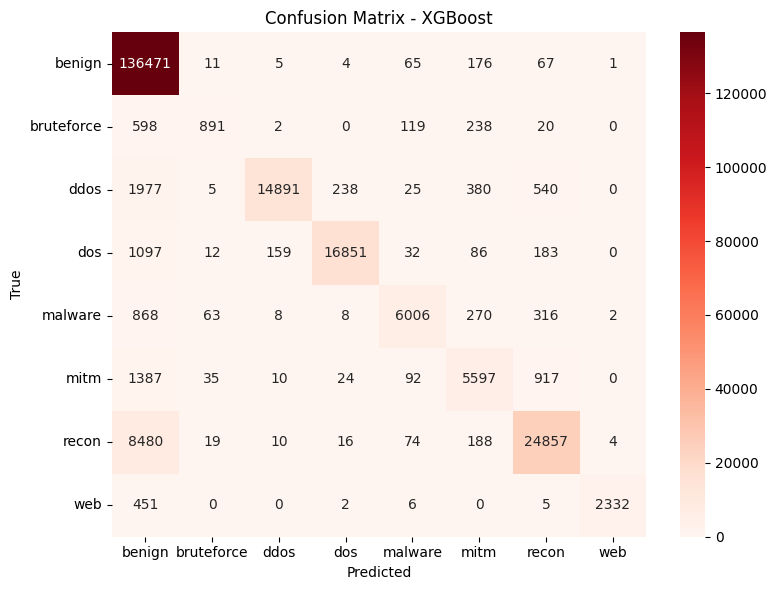

In [18]:
# Map model names to their OOF predictions
oof_map = {
    "Logistic Regression": lr_oof_preds,
    "Random Forest": rf_oof_preds,
    "K-means Clustering": kmeans_oof_preds,
    "K-Nearest Neighbors": knn_oof_preds,
    "LightGBM": oof_lgbm_preds,
    "XGBoost": xgb_oof_preds
}

best_model_name = summary_df.index[0]
best_oof_preds = oof_map[best_model_name]

print(f"\nBest Model: {best_model_name}")

if isinstance(best_oof_preds, np.ndarray):
    print("\nDetailed Report:")
    print(classification_report(y, best_oof_preds, digits=4, zero_division=0))

    cm = confusion_matrix(y, best_oof_preds, labels=sorted(y.unique()))
    cm_df = pd.DataFrame(cm, index=sorted(y.unique()), columns=sorted(y.unique()))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Reds")
    plt.title(f"Confusion Matrix - {best_model_name}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

else:
    print("OOF predictions are not in expected format for detailed reporting.")